# Ball Bessel Eigenproblem

\begin{align}
\nabla^2 f + \kappa^2 f &= 0 \\
f(r=1) &= 0
\end{align}

In [1]:
import dedalus_sphere.zernike as Zernike

import numpy as np
import scipy as sp
import scipy.sparse as sparse
from scipy.special import spherical_jn
from scipy.linalg import eig
import matplotlib.pyplot as plt
%matplotlib notebook

np.set_printoptions(precision=3,suppress=True)

dim = 3
D = Zernike.operator(dim, 'D')
E = Zernike.operator(dim, 'E')


### Bessel Parameters

In [2]:
# Shared Bessel parameters
Nmax, alpha, ell = 512, 0, 50

In [9]:
def eigsort(A, B, cutoff=np.inf):
    vals, vecs = eig(A, b=B)
    bad = (np.abs(vals) > cutoff)
    vals[bad] = np.nan
    vecs = vecs[:,np.isfinite(vals)]
    vals = vals[np.isfinite(vals)]

    i = np.argsort(vals.real)
    vals, vecs = vals[i], vecs[:, i]

    return vals, vecs


### Analytic Solution

In [4]:
def dispersion_zeros(ell,n,a=0,guess=None,imax=20,nk=10,eps=0.1):
    j = spherical_jn
    def F(k,deriv=False): 
        return j(ell,k,derivative=deriv) - a*j(ell+2,k,derivative=deriv)
    
    if guess == None:    
        kmax = np.pi*(n+ell/2 + eps)
        k = np.linspace(0,kmax,int(kmax*nk))
        S = np.sign(F(k))
        i = np.where(np.abs(np.roll(S,-1)-S)==2)[0]
        k = 0.5*(k[i]+k[i+1])
    else: k = guess
    
    for i in range(imax):
        dk =  F(k)/F(k,deriv=True)
        k -= dk
    
    return k

# Bessel equation, analytic eigenvalues
evalues_analytic = dispersion_zeros(ell,Nmax)


### Tau Method

In [5]:
# Bessel equation, tau
L = D(-1) @ D(+1)
M = -E(+1)**2

L = L(Nmax, alpha, ell)
M = M(Nmax, alpha, ell).tolil()

bc = Zernike.polynomials(dim,Nmax,alpha,ell,+1)
L = sparse.vstack([L, bc])
M[-1,:] = 0

evalues_tau, evectors_tau = eigsort(L.todense(), M.todense())
evalues_tau = np.sqrt(evalues_tau.real)

### Galerkin Method

In [6]:
# Bessel equation, galerkin
L = D(-1) @ D(+1) @ E(-1)
M = -E(+1)**2 @ E(-1)

L = L(Nmax, alpha+1, ell)
M = M(Nmax, alpha+1, ell)
M = M[:Nmax,:]

evalues_galerkin, evectors_galerkin = eigsort(L.todense(), M.todense())
evalues_galerkin = np.sqrt(evalues_galerkin.real)

### Galerkin Method, Self-Adjoint

In [7]:
# Bessel equation, self adjoint
L = D(-1)(Nmax,0,ell+1) @ D(-1)(Nmax,0,ell+1).T
M = E(+1)(Nmax,0,ell) @ E(+1)(Nmax,0,ell).T

# Check symmetry
assert np.max(abs(L - L.T)) < 1e-15
assert np.max(abs(M - M.T)) < 1e-15

evalues_symmetric, evectors_symmetric = eigsort(L.todense(), M.todense())
evalues_symmetric = np.sqrt(evalues_symmetric.real)

### Plot the Errors

<IPython.core.display.Javascript object>


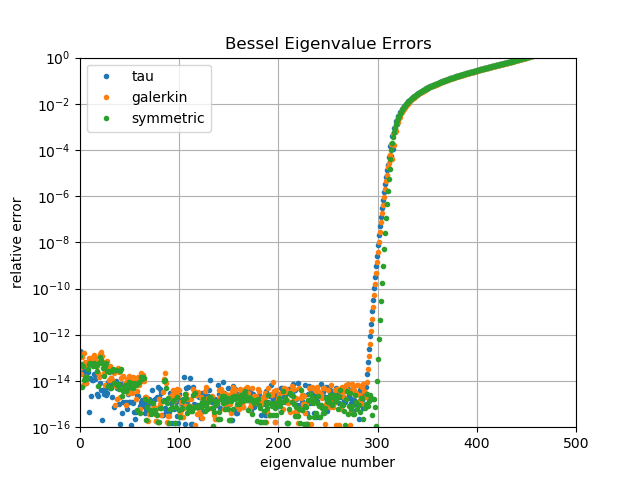

In [8]:
def error(vals):
    return np.abs(vals - evalues_analytic[:len(vals)])/np.abs(evalues_analytic[:len(vals)])

errors_tau = error(evalues_tau)
errors_galerkin = error(evalues_galerkin)
errors_symmetric = error(evalues_symmetric)

plt.figure()
plt.semilogy(errors_tau, '.', label='tau')
plt.semilogy(errors_galerkin, '.', label='galerkin')
plt.semilogy(errors_symmetric, '.', label='symmetric')
plt.xlim([0,500])
plt.ylim([10**-16,10**0])
plt.legend()
plt.xlabel('eigenvalue number')
plt.ylabel('relative error')
plt.title('Bessel Eigenvalue Errors')
plt.grid()
